In [1]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [2]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)[:3, :, :]
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction


# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [3]:
DATA_PATH = '../data/'
TRAIN_SIZE = 0.9
BATCH_SIZE = 4
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector_resnet101_anc.pt'
OCR_MODEL_PATH = 'ocr_rensenet50.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import BackboneWithFPN, resnet_fpn_backbone

def get_detector_model():
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    
    anchor_sizes = ((8,), (16,), (32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.25, 0.5, 1.0, 2.0),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(
        sizes = anchor_sizes,
        aspect_ratios=aspect_ratios
        
    )
    
    model = MaskRCNN(
        backbone,
        num_classes = 2,
        rpn_anchor_generator=anchor_generator
    )
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

In [5]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='../data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='../data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

In [6]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|          | 0/5767 [00:00<?, ?it/s]/home/kovalexal/.conda/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
  0%|          | 20/5767 [00:12<58:45,  1.63it/s]  

Loss: 1.1928442


  1%|          | 40/5767 [00:24<53:54,  1.77it/s]  

Loss: 0.5825107


  1%|          | 60/5767 [00:36<53:57,  1.76it/s]  

Loss: 0.5251399


  1%|▏         | 80/5767 [00:47<52:28,  1.81it/s]

Loss: 0.4328164


  2%|▏         | 100/5767 [00:59<54:36,  1.73it/s] 

Loss: 0.3648197


  2%|▏         | 120/5767 [01:10<56:04,  1.68it/s]  

Loss: 0.3091819


  2%|▏         | 140/5767 [01:22<52:00,  1.80it/s]

Loss: 0.2802004


  3%|▎         | 160/5767 [01:33<53:37,  1.74it/s]

Loss: 0.2681826


  3%|▎         | 180/5767 [01:45<53:29,  1.74it/s]

Loss: 0.3054368


  3%|▎         | 200/5767 [01:57<54:10,  1.71it/s]

Loss: 0.2541299


  4%|▍         | 220/5767 [02:08<53:31,  1.73it/s]

Loss: 0.2494214


  4%|▍         | 240/5767 [02:20<54:05,  1.70it/s]

Loss: 0.2673786


  5%|▍         | 260/5767 [02:32<54:05,  1.70it/s]  

Loss: 0.2615489


  5%|▍         | 280/5767 [02:44<53:44,  1.70it/s]

Loss: 0.2569786


  5%|▌         | 300/5767 [02:56<53:27,  1.70it/s]

Loss: 0.2389695


  6%|▌         | 320/5767 [03:08<51:11,  1.77it/s]

Loss: 0.2361957


  6%|▌         | 340/5767 [03:20<51:00,  1.77it/s]

Loss: 0.2060231


  6%|▌         | 360/5767 [03:31<51:56,  1.73it/s]

Loss: 0.1858678


  7%|▋         | 380/5767 [03:42<52:46,  1.70it/s]

Loss: 0.2275613


  7%|▋         | 400/5767 [03:54<53:53,  1.66it/s]

Loss: 0.2269210


  7%|▋         | 420/5767 [04:06<50:04,  1.78it/s]

Loss: 0.2244293


  8%|▊         | 440/5767 [04:18<52:18,  1.70it/s]

Loss: 0.1950792


  8%|▊         | 460/5767 [04:29<50:35,  1.75it/s]

Loss: 0.1953787


  8%|▊         | 480/5767 [04:41<52:11,  1.69it/s]

Loss: 0.2416994


  9%|▊         | 500/5767 [04:53<54:23,  1.61it/s]

Loss: 0.1928358


  9%|▉         | 520/5767 [05:05<53:53,  1.62it/s]

Loss: 0.1844849


  9%|▉         | 540/5767 [05:17<50:10,  1.74it/s]

Loss: 0.1850677


 10%|▉         | 560/5767 [05:28<48:44,  1.78it/s]

Loss: 0.1588249


 10%|█         | 580/5767 [05:40<49:13,  1.76it/s]

Loss: 0.1727405


 10%|█         | 600/5767 [05:52<52:32,  1.64it/s]

Loss: 0.1778132


 11%|█         | 620/5767 [06:04<48:42,  1.76it/s]

Loss: 0.1883098


 11%|█         | 640/5767 [06:16<53:12,  1.61it/s]

Loss: 0.1892574


 11%|█▏        | 660/5767 [06:28<52:02,  1.64it/s]

Loss: 0.1931019


 12%|█▏        | 680/5767 [06:40<53:04,  1.60it/s]

Loss: 0.1875497


 12%|█▏        | 700/5767 [06:52<49:39,  1.70it/s]

Loss: 0.1848584


 12%|█▏        | 720/5767 [07:04<52:55,  1.59it/s]

Loss: 0.1941113


 13%|█▎        | 740/5767 [07:16<49:55,  1.68it/s]

Loss: 0.2119990


 13%|█▎        | 760/5767 [07:28<50:32,  1.65it/s]

Loss: 0.1723741


 14%|█▎        | 780/5767 [07:39<48:37,  1.71it/s]

Loss: 0.2088451


 14%|█▍        | 800/5767 [07:51<51:11,  1.62it/s]

Loss: 0.1817165


 14%|█▍        | 820/5767 [08:04<53:02,  1.55it/s]

Loss: 0.1867015


 15%|█▍        | 840/5767 [08:17<52:19,  1.57it/s]

Loss: 0.1856872


 15%|█▍        | 860/5767 [08:30<50:55,  1.61it/s]

Loss: 0.2048135


 15%|█▌        | 880/5767 [08:42<48:05,  1.69it/s]

Loss: 0.2401992


 16%|█▌        | 900/5767 [08:54<47:04,  1.72it/s]

Loss: 0.1723424


 16%|█▌        | 920/5767 [09:06<50:14,  1.61it/s]

Loss: 0.1702579


 16%|█▋        | 940/5767 [09:18<50:07,  1.61it/s]

Loss: 0.1792964


 17%|█▋        | 960/5767 [09:30<51:28,  1.56it/s]

Loss: 0.1972418


 17%|█▋        | 980/5767 [09:42<46:42,  1.71it/s]

Loss: 0.2050340
Epoch    49: reducing learning rate of group 0 to 1.5000e-04.


 17%|█▋        | 1000/5767 [09:55<50:33,  1.57it/s]

Loss: 0.1752653


 18%|█▊        | 1020/5767 [10:07<48:08,  1.64it/s]

Loss: 0.1580294


 18%|█▊        | 1040/5767 [10:20<49:46,  1.58it/s]

Loss: 0.1746783


 18%|█▊        | 1060/5767 [10:32<45:01,  1.74it/s]

Loss: 0.1889295


 19%|█▊        | 1080/5767 [10:44<48:07,  1.62it/s]

Loss: 0.1738416


 19%|█▉        | 1100/5767 [10:56<48:00,  1.62it/s]

Loss: 0.1824870


 19%|█▉        | 1120/5767 [11:08<49:22,  1.57it/s]

Loss: 0.1666656


 20%|█▉        | 1140/5767 [11:20<46:07,  1.67it/s]

Loss: 0.1818552


 20%|██        | 1160/5767 [11:32<44:38,  1.72it/s]

Loss: 0.1741690


 20%|██        | 1180/5767 [11:44<45:29,  1.68it/s]

Loss: 0.1729788


 21%|██        | 1200/5767 [11:56<43:17,  1.76it/s]

Loss: 0.1747713


 21%|██        | 1220/5767 [12:09<46:35,  1.63it/s]

Loss: 0.1648932


 22%|██▏       | 1240/5767 [12:21<43:20,  1.74it/s]

Loss: 0.1535093


 22%|██▏       | 1260/5767 [12:33<44:51,  1.67it/s]

Loss: 0.1437385


 22%|██▏       | 1280/5767 [12:45<46:33,  1.61it/s]

Loss: 0.1714420


 23%|██▎       | 1300/5767 [12:58<45:09,  1.65it/s]

Loss: 0.1784649


 23%|██▎       | 1320/5767 [13:09<43:50,  1.69it/s]

Loss: 0.1596885


 23%|██▎       | 1340/5767 [13:21<43:13,  1.71it/s]

Loss: 0.1706488


 24%|██▎       | 1360/5767 [13:33<44:03,  1.67it/s]

Loss: 0.1722328


 24%|██▍       | 1380/5767 [13:45<45:51,  1.59it/s]

Loss: 0.1815906


 24%|██▍       | 1400/5767 [13:57<42:35,  1.71it/s]

Loss: 0.1658223


 25%|██▍       | 1420/5767 [14:10<47:33,  1.52it/s]

Loss: 0.1686559


 25%|██▍       | 1440/5767 [14:22<48:29,  1.49it/s]

Loss: 0.1695639


 25%|██▌       | 1460/5767 [14:35<43:10,  1.66it/s]

Loss: 0.1775737


 26%|██▌       | 1480/5767 [14:47<43:50,  1.63it/s]

Loss: 0.1723941


 26%|██▌       | 1500/5767 [14:59<44:19,  1.60it/s]

Loss: 0.1549744


 26%|██▋       | 1520/5767 [15:12<45:56,  1.54it/s]

Loss: 0.1669341


 27%|██▋       | 1540/5767 [15:23<42:18,  1.67it/s]

Loss: 0.1564025


 27%|██▋       | 1560/5767 [15:36<44:56,  1.56it/s]

Loss: 0.1667096


 27%|██▋       | 1580/5767 [15:48<42:19,  1.65it/s]

Loss: 0.1575290


 28%|██▊       | 1600/5767 [16:00<43:05,  1.61it/s]

Loss: 0.1630103


 28%|██▊       | 1620/5767 [16:14<44:07,  1.57it/s]

Loss: 0.1541863


 28%|██▊       | 1640/5767 [16:26<40:55,  1.68it/s]

Loss: 0.1494657


 29%|██▉       | 1660/5767 [16:39<44:33,  1.54it/s]

Loss: 0.1833706


 29%|██▉       | 1680/5767 [16:51<41:33,  1.64it/s]

Loss: 0.1631319
Epoch    84: reducing learning rate of group 0 to 7.5000e-05.


 29%|██▉       | 1700/5767 [17:03<42:33,  1.59it/s]

Loss: 0.1512444


 30%|██▉       | 1720/5767 [17:16<42:11,  1.60it/s]

Loss: 0.1508709


 30%|███       | 1740/5767 [17:29<43:51,  1.53it/s]

Loss: 0.1510216


 31%|███       | 1760/5767 [17:41<38:00,  1.76it/s]

Loss: 0.1635431


 31%|███       | 1780/5767 [17:53<38:39,  1.72it/s]

Loss: 0.1527089


 31%|███       | 1800/5767 [18:05<40:07,  1.65it/s]

Loss: 0.1432142


 32%|███▏      | 1820/5767 [18:18<41:42,  1.58it/s]

Loss: 0.1571149


 32%|███▏      | 1840/5767 [18:30<37:51,  1.73it/s]

Loss: 0.1567076


 32%|███▏      | 1860/5767 [18:42<38:35,  1.69it/s]

Loss: 0.1485678


 33%|███▎      | 1880/5767 [18:54<38:25,  1.69it/s]

Loss: 0.1543245


 33%|███▎      | 1900/5767 [19:06<39:21,  1.64it/s]

Loss: 0.1639673


 33%|███▎      | 1920/5767 [19:18<36:54,  1.74it/s]

Loss: 0.1402804


 34%|███▎      | 1940/5767 [19:30<35:47,  1.78it/s]

Loss: 0.1511217


 34%|███▍      | 1960/5767 [19:42<37:49,  1.68it/s]

Loss: 0.1554647


 34%|███▍      | 1980/5767 [19:54<38:33,  1.64it/s]

Loss: 0.1866797


 35%|███▍      | 2000/5767 [20:06<37:57,  1.65it/s]

Loss: 0.1668089


 35%|███▌      | 2020/5767 [20:19<37:01,  1.69it/s]

Loss: 0.1654559


 35%|███▌      | 2040/5767 [20:31<38:21,  1.62it/s]

Loss: 0.1575397


 36%|███▌      | 2060/5767 [20:43<35:04,  1.76it/s]

Loss: 0.1433540


 36%|███▌      | 2080/5767 [20:55<37:37,  1.63it/s]

Loss: 0.1717538


 36%|███▋      | 2100/5767 [21:07<39:06,  1.56it/s]

Loss: 0.1437670


 37%|███▋      | 2120/5767 [21:19<36:32,  1.66it/s]

Loss: 0.1436654


 37%|███▋      | 2140/5767 [21:31<37:15,  1.62it/s]

Loss: 0.1486203


 37%|███▋      | 2160/5767 [21:43<35:18,  1.70it/s]

Loss: 0.1653991


 38%|███▊      | 2180/5767 [21:56<37:15,  1.60it/s]

Loss: 0.1437785


 38%|███▊      | 2200/5767 [22:07<35:43,  1.66it/s]

Loss: 0.1635502


 38%|███▊      | 2220/5767 [22:20<36:54,  1.60it/s]

Loss: 0.1707210


 39%|███▉      | 2240/5767 [22:32<37:14,  1.58it/s]

Loss: 0.1540790


 39%|███▉      | 2260/5767 [22:44<34:44,  1.68it/s]

Loss: 0.1501881


 40%|███▉      | 2280/5767 [22:56<35:28,  1.64it/s]

Loss: 0.1778791


 40%|███▉      | 2300/5767 [23:08<34:04,  1.70it/s]

Loss: 0.1644565


 40%|████      | 2320/5767 [23:20<36:13,  1.59it/s]

Loss: 0.1590408


 41%|████      | 2340/5767 [23:32<33:55,  1.68it/s]

Loss: 0.1452054
Epoch   117: reducing learning rate of group 0 to 3.7500e-05.


 41%|████      | 2360/5767 [23:44<33:38,  1.69it/s]

Loss: 0.1469914


 41%|████▏     | 2380/5767 [23:56<33:44,  1.67it/s]

Loss: 0.1527263


 42%|████▏     | 2400/5767 [24:08<33:32,  1.67it/s]

Loss: 0.1593135


 42%|████▏     | 2420/5767 [24:20<32:51,  1.70it/s]

Loss: 0.1454062


 42%|████▏     | 2440/5767 [24:31<31:26,  1.76it/s]

Loss: 0.1462551


 43%|████▎     | 2460/5767 [24:44<32:58,  1.67it/s]

Loss: 0.1425260


 43%|████▎     | 2480/5767 [24:56<34:51,  1.57it/s]

Loss: 0.1600390


 43%|████▎     | 2500/5767 [25:08<30:53,  1.76it/s]

Loss: 0.1786439


 44%|████▎     | 2520/5767 [25:20<32:58,  1.64it/s]

Loss: 0.1387557


 44%|████▍     | 2540/5767 [25:32<32:38,  1.65it/s]

Loss: 0.1428306


 44%|████▍     | 2560/5767 [25:44<33:48,  1.58it/s]

Loss: 0.1395664


 45%|████▍     | 2580/5767 [25:56<32:30,  1.63it/s]

Loss: 0.1813731


 45%|████▌     | 2600/5767 [26:08<30:52,  1.71it/s]

Loss: 0.1452842


 45%|████▌     | 2620/5767 [26:20<32:07,  1.63it/s]

Loss: 0.1566397


 46%|████▌     | 2640/5767 [26:32<31:12,  1.67it/s]

Loss: 0.1591454


 46%|████▌     | 2660/5767 [26:44<30:02,  1.72it/s]

Loss: 0.1513741


 46%|████▋     | 2680/5767 [26:56<30:23,  1.69it/s]

Loss: 0.1481581


 47%|████▋     | 2700/5767 [27:07<30:15,  1.69it/s]

Loss: 0.1389292


 47%|████▋     | 2720/5767 [27:19<29:33,  1.72it/s]

Loss: 0.1486559


 48%|████▊     | 2740/5767 [27:32<31:34,  1.60it/s]

Loss: 0.1617797


 48%|████▊     | 2760/5767 [27:44<30:48,  1.63it/s]

Loss: 0.1874577


 48%|████▊     | 2780/5767 [27:55<29:35,  1.68it/s]

Loss: 0.1489166


 49%|████▊     | 2800/5767 [28:08<31:19,  1.58it/s]

Loss: 0.1723551


 49%|████▉     | 2820/5767 [28:20<29:06,  1.69it/s]

Loss: 0.1552642


 49%|████▉     | 2840/5767 [28:33<31:10,  1.56it/s]

Loss: 0.1592324


 50%|████▉     | 2860/5767 [28:45<29:50,  1.62it/s]

Loss: 0.1391446


 50%|████▉     | 2880/5767 [28:57<28:48,  1.67it/s]

Loss: 0.1399766


 50%|█████     | 2900/5767 [29:10<29:15,  1.63it/s]

Loss: 0.1780420


 51%|█████     | 2920/5767 [29:22<29:25,  1.61it/s]

Loss: 0.1448581


 51%|█████     | 2940/5767 [29:34<28:51,  1.63it/s]

Loss: 0.1542602
Epoch   147: reducing learning rate of group 0 to 1.8750e-05.


 51%|█████▏    | 2960/5767 [29:46<28:48,  1.62it/s]

Loss: 0.1486235


 52%|█████▏    | 2980/5767 [29:58<29:10,  1.59it/s]

Loss: 0.1599408


 52%|█████▏    | 3000/5767 [30:11<28:25,  1.62it/s]

Loss: 0.1441185


 52%|█████▏    | 3020/5767 [30:23<29:33,  1.55it/s]

Loss: 0.1404378


 53%|█████▎    | 3040/5767 [30:36<28:05,  1.62it/s]

Loss: 0.1404816


 53%|█████▎    | 3060/5767 [30:48<28:51,  1.56it/s]

Loss: 0.1384491


 53%|█████▎    | 3080/5767 [31:01<28:25,  1.58it/s]

Loss: 0.1517701


 54%|█████▍    | 3100/5767 [31:14<28:59,  1.53it/s]

Loss: 0.1530647


 54%|█████▍    | 3120/5767 [31:26<26:37,  1.66it/s]

Loss: 0.1483156


 54%|█████▍    | 3140/5767 [31:38<26:27,  1.66it/s]

Loss: 0.1387889


 55%|█████▍    | 3160/5767 [31:50<25:39,  1.69it/s]

Loss: 0.1541541


 55%|█████▌    | 3180/5767 [32:02<25:23,  1.70it/s]

Loss: 0.1620314


 55%|█████▌    | 3200/5767 [32:14<27:05,  1.58it/s]

Loss: 0.1424563


 56%|█████▌    | 3220/5767 [32:27<26:27,  1.60it/s]

Loss: 0.1429477


 56%|█████▌    | 3240/5767 [32:39<28:19,  1.49it/s]

Loss: 0.1611888


 57%|█████▋    | 3260/5767 [32:52<26:43,  1.56it/s]

Loss: 0.1437923


 57%|█████▋    | 3280/5767 [33:04<25:31,  1.62it/s]

Loss: 0.1292027


 57%|█████▋    | 3300/5767 [33:17<24:47,  1.66it/s]

Loss: 0.1520032


 58%|█████▊    | 3320/5767 [33:29<25:51,  1.58it/s]

Loss: 0.1432442


 58%|█████▊    | 3340/5767 [33:41<24:26,  1.66it/s]

Loss: 0.1600414


 58%|█████▊    | 3360/5767 [33:53<23:03,  1.74it/s]

Loss: 0.1475907


 59%|█████▊    | 3380/5767 [34:06<24:31,  1.62it/s]

Loss: 0.1488338


 59%|█████▉    | 3400/5767 [34:18<24:02,  1.64it/s]

Loss: 0.1526446


 59%|█████▉    | 3420/5767 [34:31<23:49,  1.64it/s]

Loss: 0.1485174


 60%|█████▉    | 3440/5767 [34:44<23:47,  1.63it/s]

Loss: 0.1463967


 60%|█████▉    | 3460/5767 [34:56<23:19,  1.65it/s]

Loss: 0.1554390


 60%|██████    | 3480/5767 [35:07<22:51,  1.67it/s]

Loss: 0.1426118


 61%|██████    | 3500/5767 [35:19<22:15,  1.70it/s]

Loss: 0.1588193


 61%|██████    | 3520/5767 [35:32<22:47,  1.64it/s]

Loss: 0.1475325


 61%|██████▏   | 3540/5767 [35:44<22:52,  1.62it/s]

Loss: 0.1365841


 62%|██████▏   | 3560/5767 [35:56<22:27,  1.64it/s]

Loss: 0.1391078


 62%|██████▏   | 3580/5767 [36:08<21:13,  1.72it/s]

Loss: 0.1766573


 62%|██████▏   | 3600/5767 [36:20<21:45,  1.66it/s]

Loss: 0.1377603


 63%|██████▎   | 3620/5767 [36:32<21:39,  1.65it/s]

Loss: 0.1430749


 63%|██████▎   | 3640/5767 [36:44<20:05,  1.76it/s]

Loss: 0.1400974


 63%|██████▎   | 3660/5767 [36:56<21:18,  1.65it/s]

Loss: 0.1553601


 64%|██████▍   | 3680/5767 [37:08<20:08,  1.73it/s]

Loss: 0.1406157


 64%|██████▍   | 3700/5767 [37:20<20:09,  1.71it/s]

Loss: 0.1479806
Epoch   185: reducing learning rate of group 0 to 9.3750e-06.


 65%|██████▍   | 3720/5767 [37:32<21:05,  1.62it/s]

Loss: 0.1572101


 65%|██████▍   | 3740/5767 [37:44<21:11,  1.59it/s]

Loss: 0.1464020


 65%|██████▌   | 3760/5767 [37:56<20:32,  1.63it/s]

Loss: 0.1411085


 66%|██████▌   | 3780/5767 [38:09<20:24,  1.62it/s]

Loss: 0.1592192


 66%|██████▌   | 3800/5767 [38:21<19:58,  1.64it/s]

Loss: 0.1614857


 66%|██████▌   | 3820/5767 [38:33<21:00,  1.54it/s]

Loss: 0.1532408


 67%|██████▋   | 3840/5767 [38:45<19:13,  1.67it/s]

Loss: 0.1601391


 67%|██████▋   | 3860/5767 [38:57<19:13,  1.65it/s]

Loss: 0.1368260


 67%|██████▋   | 3880/5767 [39:09<18:47,  1.67it/s]

Loss: 0.1455609


 68%|██████▊   | 3900/5767 [39:21<19:12,  1.62it/s]

Loss: 0.1433116


 68%|██████▊   | 3920/5767 [39:33<18:13,  1.69it/s]

Loss: 0.1601782


 68%|██████▊   | 3940/5767 [39:46<19:21,  1.57it/s]

Loss: 0.1407834


 69%|██████▊   | 3960/5767 [39:58<17:48,  1.69it/s]

Loss: 0.1445751


 69%|██████▉   | 3980/5767 [40:10<18:46,  1.59it/s]

Loss: 0.1468739


 69%|██████▉   | 4000/5767 [40:22<18:50,  1.56it/s]

Loss: 0.1400806


 70%|██████▉   | 4020/5767 [40:34<17:05,  1.70it/s]

Loss: 0.1420719


 70%|███████   | 4040/5767 [40:46<17:36,  1.63it/s]

Loss: 0.1524811


 70%|███████   | 4060/5767 [40:59<17:08,  1.66it/s]

Loss: 0.1527346


 71%|███████   | 4080/5767 [41:10<17:22,  1.62it/s]

Loss: 0.1662149


 71%|███████   | 4100/5767 [41:23<17:16,  1.61it/s]

Loss: 0.1707659


 71%|███████▏  | 4120/5767 [41:35<17:09,  1.60it/s]

Loss: 0.1532286
Epoch   206: reducing learning rate of group 0 to 4.6875e-06.


 72%|███████▏  | 4140/5767 [41:47<16:19,  1.66it/s]

Loss: 0.1616638


 72%|███████▏  | 4160/5767 [41:59<17:11,  1.56it/s]

Loss: 0.1631600


 72%|███████▏  | 4180/5767 [42:11<16:14,  1.63it/s]

Loss: 0.1495454


 73%|███████▎  | 4200/5767 [42:23<16:44,  1.56it/s]

Loss: 0.1446129


 73%|███████▎  | 4220/5767 [42:35<15:29,  1.67it/s]

Loss: 0.1316961


 74%|███████▎  | 4240/5767 [42:47<14:50,  1.72it/s]

Loss: 0.1481508


 74%|███████▍  | 4260/5767 [42:59<15:16,  1.64it/s]

Loss: 0.1532046


 74%|███████▍  | 4280/5767 [43:12<15:43,  1.58it/s]

Loss: 0.1495018


 75%|███████▍  | 4300/5767 [43:23<13:53,  1.76it/s]

Loss: 0.1617674


 75%|███████▍  | 4320/5767 [43:36<14:36,  1.65it/s]

Loss: 0.1412738


 75%|███████▌  | 4340/5767 [43:48<14:55,  1.59it/s]

Loss: 0.1744249


 76%|███████▌  | 4360/5767 [44:00<13:58,  1.68it/s]

Loss: 0.1374352


 76%|███████▌  | 4380/5767 [44:12<13:10,  1.75it/s]

Loss: 0.1524636


 76%|███████▋  | 4400/5767 [44:25<14:20,  1.59it/s]

Loss: 0.1402546


 77%|███████▋  | 4420/5767 [44:37<14:27,  1.55it/s]

Loss: 0.1555628


 77%|███████▋  | 4440/5767 [44:49<13:02,  1.70it/s]

Loss: 0.1438646


 77%|███████▋  | 4460/5767 [45:01<12:49,  1.70it/s]

Loss: 0.1454772


 78%|███████▊  | 4480/5767 [45:13<12:31,  1.71it/s]

Loss: 0.1322897


 78%|███████▊  | 4500/5767 [45:25<12:34,  1.68it/s]

Loss: 0.1490032


 78%|███████▊  | 4520/5767 [45:37<12:54,  1.61it/s]

Loss: 0.1479015


 79%|███████▊  | 4540/5767 [45:49<11:53,  1.72it/s]

Loss: 0.1489946
Epoch   227: reducing learning rate of group 0 to 2.3437e-06.


 79%|███████▉  | 4560/5767 [46:02<11:58,  1.68it/s]

Loss: 0.1338814


 79%|███████▉  | 4580/5767 [46:14<11:51,  1.67it/s]

Loss: 0.1412624


 80%|███████▉  | 4600/5767 [46:26<11:56,  1.63it/s]

Loss: 0.1385959


 80%|████████  | 4620/5767 [46:38<11:18,  1.69it/s]

Loss: 0.1525141


 80%|████████  | 4640/5767 [46:50<10:56,  1.72it/s]

Loss: 0.1634714


 81%|████████  | 4660/5767 [47:02<10:51,  1.70it/s]

Loss: 0.1741066


 81%|████████  | 4680/5767 [47:14<11:11,  1.62it/s]

Loss: 0.1674681


 81%|████████▏ | 4700/5767 [47:26<10:48,  1.65it/s]

Loss: 0.1417667


 82%|████████▏ | 4720/5767 [47:38<10:50,  1.61it/s]

Loss: 0.1577738


 82%|████████▏ | 4740/5767 [47:51<09:59,  1.71it/s]

Loss: 0.1575711


 83%|████████▎ | 4760/5767 [48:03<10:11,  1.65it/s]

Loss: 0.1520369


 83%|████████▎ | 4780/5767 [48:15<09:43,  1.69it/s]

Loss: 0.1455634


 83%|████████▎ | 4800/5767 [48:27<09:18,  1.73it/s]

Loss: 0.1646758


 84%|████████▎ | 4820/5767 [48:38<09:16,  1.70it/s]

Loss: 0.1631730


 84%|████████▍ | 4840/5767 [48:51<09:25,  1.64it/s]

Loss: 0.1739548


 84%|████████▍ | 4860/5767 [49:03<09:31,  1.59it/s]

Loss: 0.1661586


 85%|████████▍ | 4880/5767 [49:15<09:07,  1.62it/s]

Loss: 0.1500366


 85%|████████▍ | 4900/5767 [49:27<08:31,  1.69it/s]

Loss: 0.1291582


 85%|████████▌ | 4920/5767 [49:39<08:37,  1.64it/s]

Loss: 0.1404700


 86%|████████▌ | 4940/5767 [49:51<08:42,  1.58it/s]

Loss: 0.1583967


 86%|████████▌ | 4960/5767 [50:03<08:07,  1.65it/s]

Loss: 0.1450402


 86%|████████▋ | 4980/5767 [50:16<08:09,  1.61it/s]

Loss: 0.1467807


 87%|████████▋ | 5000/5767 [50:28<07:32,  1.70it/s]

Loss: 0.1411089


 87%|████████▋ | 5020/5767 [50:40<07:27,  1.67it/s]

Loss: 0.1465662


 87%|████████▋ | 5040/5767 [50:52<07:16,  1.67it/s]

Loss: 0.1511733


 88%|████████▊ | 5060/5767 [51:04<07:12,  1.63it/s]

Loss: 0.1332244


 88%|████████▊ | 5080/5767 [51:16<07:10,  1.59it/s]

Loss: 0.1562451


 88%|████████▊ | 5100/5767 [51:28<06:37,  1.68it/s]

Loss: 0.1414918


 89%|████████▉ | 5120/5767 [51:40<06:18,  1.71it/s]

Loss: 0.1421461


 89%|████████▉ | 5140/5767 [51:52<06:13,  1.68it/s]

Loss: 0.1409809


 89%|████████▉ | 5160/5767 [52:04<06:24,  1.58it/s]

Loss: 0.1361722


 90%|████████▉ | 5180/5767 [52:16<06:01,  1.62it/s]

Loss: 0.1457509


 90%|█████████ | 5200/5767 [52:28<05:32,  1.71it/s]

Loss: 0.1535208


 91%|█████████ | 5220/5767 [52:40<05:35,  1.63it/s]

Loss: 0.1511453


 91%|█████████ | 5240/5767 [52:52<05:05,  1.72it/s]

Loss: 0.1363338


 91%|█████████ | 5260/5767 [53:04<05:26,  1.55it/s]

Loss: 0.1622081


 92%|█████████▏| 5280/5767 [53:17<04:57,  1.64it/s]

Loss: 0.1518858


 92%|█████████▏| 5300/5767 [53:30<04:36,  1.69it/s]

Loss: 0.1497896


 92%|█████████▏| 5320/5767 [53:42<04:20,  1.72it/s]

Loss: 0.1479578
Epoch   266: reducing learning rate of group 0 to 1.1719e-06.


 93%|█████████▎| 5340/5767 [53:54<04:21,  1.63it/s]

Loss: 0.1615144


 93%|█████████▎| 5360/5767 [54:06<03:58,  1.70it/s]

Loss: 0.1446337


 93%|█████████▎| 5380/5767 [54:18<03:49,  1.69it/s]

Loss: 0.1493653


 94%|█████████▎| 5400/5767 [54:30<03:40,  1.66it/s]

Loss: 0.1508031


 94%|█████████▍| 5420/5767 [54:42<03:21,  1.72it/s]

Loss: 0.1412855


 94%|█████████▍| 5440/5767 [54:54<03:25,  1.59it/s]

Loss: 0.1476306


 95%|█████████▍| 5460/5767 [55:06<03:00,  1.70it/s]

Loss: 0.1445021


 95%|█████████▌| 5480/5767 [55:18<02:44,  1.74it/s]

Loss: 0.1358922


 95%|█████████▌| 5500/5767 [55:30<02:37,  1.70it/s]

Loss: 0.1330447


 96%|█████████▌| 5520/5767 [55:42<02:26,  1.69it/s]

Loss: 0.1545297


 96%|█████████▌| 5540/5767 [55:55<02:16,  1.66it/s]

Loss: 0.1518119


 96%|█████████▋| 5560/5767 [56:07<02:05,  1.66it/s]

Loss: 0.1422968


 97%|█████████▋| 5580/5767 [56:19<01:47,  1.74it/s]

Loss: 0.1395118


 97%|█████████▋| 5600/5767 [56:31<01:43,  1.61it/s]

Loss: 0.1482175


 97%|█████████▋| 5620/5767 [56:43<01:28,  1.67it/s]

Loss: 0.1669506


 98%|█████████▊| 5640/5767 [56:55<01:14,  1.71it/s]

Loss: 0.1359754


 98%|█████████▊| 5660/5767 [57:07<01:01,  1.73it/s]

Loss: 0.1426253


 98%|█████████▊| 5680/5767 [57:19<00:53,  1.62it/s]

Loss: 0.1594606


 99%|█████████▉| 5700/5767 [57:31<00:40,  1.67it/s]

Loss: 0.1641087


 99%|█████████▉| 5720/5767 [57:43<00:28,  1.66it/s]

Loss: 0.1429832


100%|█████████▉| 5740/5767 [57:55<00:15,  1.72it/s]

Loss: 0.1621090
Epoch   287: reducing learning rate of group 0 to 5.8594e-07.


100%|█████████▉| 5760/5767 [58:08<00:04,  1.58it/s]

Loss: 0.1398684


In [10]:
torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [7]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

../data/test/2554.jpg
Class: plate, Confidence: 0.9992982149124146
Bounding box:


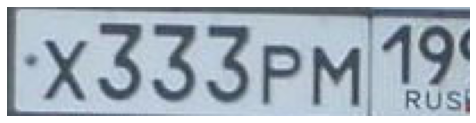

Rotated img:


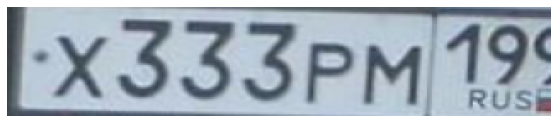

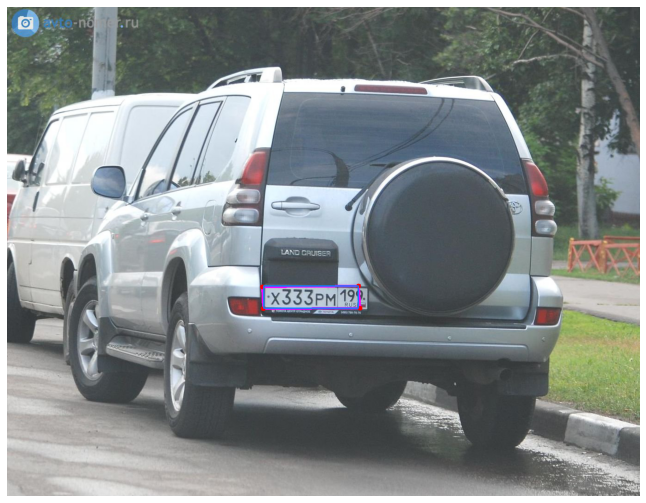

{'boxes': tensor([[554.8705, 604.6287, 758.9357, 652.4182],
         [586.8587, 522.1447, 693.5392, 544.5668]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9993, 0.0594], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}

In [11]:


img = np.random.choice(test_images)
# img = '../data/test/2661.jpg'
#img = '../data/test/1610.bmp'
#img = '../data/test/1500.jpg'
# img = '../data/test/2303.jpg'

print(img)
visualize_prediction_plate(img, model, id_to_name={1: 'plate'}, thresh=0.1)
# visualize_prediction_plate('../data/test/2661.jpg', model, id_to_name={1: 'plate'}, thresh=0.5)



In [13]:
# THRESHOLD_SCORE = 0.7
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):
# for file in tqdm.tqdm(['../data/test/1541.jpg'], position=0, leave=False):
    
    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        # В разных версиях opencv этот метод возвращает разное число параметров
        contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
        approx = simplify_contour(contours[0], n_corners=4)

        if approx is None:
            x0, y0 = x_min, y_min
            x1, y1 = x_max, y_min
            x2, y2 = x_min, y_max
            x3, y3 = x_max, y_max
        else:
            x0, y0 = approx[0][0][0], approx[0][0][1]
            x1, y1 = approx[1][0][0], approx[1][0][1]
            x2, y2 = approx[2][0][0], approx[2][0][1]
            x3, y3 = approx[3][0][0], approx[3][0][1]

        points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

        pred['nums'].append({
            'box': points,
            'bbox': [x_min, y_min, x_max, y_max],
            'score': score
        })
        
    # Попробуем сделать адаптивный порог
    pred['nums'] = sorted(pred['nums'], key=lambda x: x['score'])
    
    # Считаем адаптивный порог кривым образом
    diff, threshold = 0.05, pred['nums'][-1]['score']
    for i in range(len(pred['nums']) - 2, -1, -1):
        current_score = pred['nums'][i]['score']
        current_diff = threshold - current_score
        
        if current_diff > diff:
            break
        else:
            diff = current_diff
            threshold = current_score
        
    # Берем все, что выше порога
    pred['nums'] = list(filter(lambda x: x['score'] >= threshold, pred['nums']))

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test_04_0.7_adaptive_threshold_anc.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

  2%|▏         | 76/3188 [00:09<06:42,  7.74it/s]

simplify_contour didnt coverege


  3%|▎         | 87/3188 [00:14<1:04:40,  1.25s/it]

simplify_contour didnt coverege


  6%|▌         | 188/3188 [00:25<06:19,  7.91it/s] 

simplify_contour didnt coverege


  9%|▉         | 281/3188 [00:37<06:11,  7.82it/s]

simplify_contour didnt coverege


 10%|▉         | 309/3188 [00:40<05:37,  8.52it/s]

simplify_contour didnt coverege


 10%|▉         | 312/3188 [00:40<06:15,  7.66it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 17%|█▋        | 531/3188 [01:07<05:52,  7.54it/s]

simplify_contour didnt coverege


 17%|█▋        | 535/3188 [01:07<05:51,  7.54it/s]

simplify_contour didnt coverege


 18%|█▊        | 572/3188 [01:13<05:39,  7.70it/s]

simplify_contour didnt coverege


 21%|██        | 665/3188 [01:27<07:09,  5.87it/s]

simplify_contour didnt coverege


 24%|██▍       | 771/3188 [01:42<06:29,  6.20it/s]

simplify_contour didnt coverege


 25%|██▍       | 782/3188 [01:43<05:09,  7.77it/s]

simplify_contour didnt coverege


 25%|██▍       | 785/3188 [01:44<05:25,  7.38it/s]

simplify_contour didnt coverege


 25%|██▌       | 809/3188 [01:47<05:03,  7.85it/s]

simplify_contour didnt coverege


 26%|██▌       | 816/3188 [01:48<05:10,  7.65it/s]

simplify_contour didnt coverege


 29%|██▊       | 914/3188 [02:02<05:23,  7.04it/s]

simplify_contour didnt coverege


 29%|██▉       | 930/3188 [02:04<05:17,  7.12it/s]

simplify_contour didnt coverege


 32%|███▏      | 1032/3188 [02:19<05:36,  6.40it/s]

simplify_contour didnt coverege


 33%|███▎      | 1041/3188 [02:20<05:56,  6.03it/s]

simplify_contour didnt coverege


 39%|███▉      | 1259/3188 [02:52<03:57,  8.11it/s]

simplify_contour didnt coverege


 41%|████▏     | 1323/3188 [03:02<05:04,  6.12it/s]

simplify_contour didnt coverege


 45%|████▌     | 1445/3188 [03:19<04:14,  6.86it/s]

simplify_contour didnt coverege


 50%|████▉     | 1582/3188 [03:37<03:19,  8.07it/s]

simplify_contour didnt coverege


 52%|█████▏    | 1656/3188 [03:46<03:06,  8.23it/s]

simplify_contour didnt coverege


 52%|█████▏    | 1667/3188 [03:47<03:21,  7.54it/s]

simplify_contour didnt coverege


 56%|█████▌    | 1778/3188 [04:01<03:10,  7.39it/s]

simplify_contour didnt coverege


 59%|█████▉    | 1886/3188 [04:14<02:34,  8.41it/s]

simplify_contour didnt coverege


 66%|██████▌   | 2093/3188 [04:43<03:37,  5.03it/s]

simplify_contour didnt coverege


 69%|██████▉   | 2209/3188 [04:59<02:06,  7.74it/s]

simplify_contour didnt coverege


 73%|███████▎  | 2314/3188 [05:14<02:14,  6.51it/s]

simplify_contour didnt coverege


 73%|███████▎  | 2331/3188 [05:16<01:55,  7.40it/s]

simplify_contour didnt coverege


 74%|███████▎  | 2350/3188 [05:19<01:37,  8.60it/s]

simplify_contour didnt coverege


 75%|███████▍  | 2377/3188 [05:22<01:38,  8.20it/s]

simplify_contour didnt coverege


 77%|███████▋  | 2458/3188 [05:33<01:32,  7.92it/s]

simplify_contour didnt coverege


 79%|███████▉  | 2527/3188 [05:42<01:18,  8.41it/s]

simplify_contour didnt coverege


 83%|████████▎ | 2634/3188 [05:56<01:23,  6.66it/s]

simplify_contour didnt coverege


 84%|████████▍ | 2677/3188 [06:02<01:13,  6.93it/s]

simplify_contour didnt coverege


 85%|████████▍ | 2703/3188 [06:05<01:13,  6.63it/s]

simplify_contour didnt coverege


 87%|████████▋ | 2786/3188 [06:16<00:53,  7.57it/s]

simplify_contour didnt coverege


 89%|████████▊ | 2826/3188 [06:21<00:41,  8.83it/s]

simplify_contour didnt coverege


 89%|████████▉ | 2832/3188 [06:22<00:52,  6.82it/s]

simplify_contour didnt coverege


 89%|████████▉ | 2849/3188 [06:25<00:45,  7.44it/s]

simplify_contour didnt coverege


 96%|█████████▌| 3057/3188 [06:53<00:17,  7.39it/s]

simplify_contour didnt coverege


In [49]:
THRESHOLD_SCORE = 0.7
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE: 
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test_04_0.7.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

 10%|▉         | 309/3188 [00:34<05:27,  8.78it/s]

simplify_contour didnt coverege


 30%|██▉       | 941/3188 [01:45<03:46,  9.91it/s]

simplify_contour didnt coverege


 41%|████      | 1308/3188 [02:28<03:23,  9.24it/s]

simplify_contour didnt coverege


 49%|████▉     | 1569/3188 [02:58<03:27,  7.81it/s]

simplify_contour didnt coverege


 67%|██████▋   | 2137/3188 [04:04<01:56,  9.02it/s]

simplify_contour didnt coverege


 74%|███████▎  | 2351/3188 [04:29<01:32,  9.04it/s]

simplify_contour didnt coverege


 89%|████████▉ | 2836/3188 [05:24<00:40,  8.61it/s]

simplify_contour didnt coverege


 94%|█████████▍| 3006/3188 [05:43<00:26,  6.95it/s]

simplify_contour didnt coverege


 99%|█████████▉| 3159/3188 [06:00<00:03,  9.11it/s]

simplify_contour didnt coverege


In [23]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(520, 115)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(520, 115)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

7

In [24]:
import math

class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(115, 520), output_len=32):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet50')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(math.ceil(h / 32), 1))        
        self.proj = nn.Conv2d(math.ceil(w / 32), output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn3.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(115, 520), 
        cnn_output_len=32,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=True
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [25]:
crnn = CRNN()
#crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device)

CRNN(
  (features_extractor): FeatureExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=Tru

In [26]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [27]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  1%|          | 20/3016 [00:08<20:51,  2.39it/s]

Loss: 5.6137005


  1%|▏         | 40/3016 [00:16<21:04,  2.35it/s]

Loss: 3.4406723


  2%|▏         | 60/3016 [00:24<19:07,  2.58it/s]

Loss: 3.2386111


  3%|▎         | 80/3016 [00:32<18:40,  2.62it/s]

Loss: 3.1442830


  3%|▎         | 100/3016 [00:40<20:46,  2.34it/s]

Loss: 3.0666029


  4%|▍         | 120/3016 [00:49<20:09,  2.39it/s]

Loss: 2.9902686


  5%|▍         | 140/3016 [00:56<20:01,  2.39it/s]

Loss: 2.9370505


  5%|▌         | 160/3016 [01:05<20:10,  2.36it/s]

Loss: 2.8648185


  6%|▌         | 180/3016 [01:13<20:26,  2.31it/s]

Loss: 2.8462467


  7%|▋         | 200/3016 [01:21<21:31,  2.18it/s]

Loss: 2.8167903


  7%|▋         | 220/3016 [01:29<18:05,  2.58it/s]

Loss: 2.7927454


  8%|▊         | 240/3016 [01:37<19:11,  2.41it/s]

Loss: 2.6943847


  9%|▊         | 260/3016 [01:45<19:16,  2.38it/s]

Loss: 2.7228042


  9%|▉         | 280/3016 [01:53<20:15,  2.25it/s]

Loss: 2.6689515


 10%|▉         | 300/3016 [02:01<17:00,  2.66it/s]

Loss: 2.6331344


 11%|█         | 320/3016 [02:09<18:11,  2.47it/s]

Loss: 2.6351777


 11%|█▏        | 340/3016 [02:17<17:09,  2.60it/s]

Loss: 2.5871557


 12%|█▏        | 360/3016 [02:25<20:01,  2.21it/s]

Loss: 2.5708671


 13%|█▎        | 380/3016 [02:33<16:28,  2.67it/s]

Loss: 2.5443590


 13%|█▎        | 400/3016 [02:41<18:23,  2.37it/s]

Loss: 2.5149857


 14%|█▍        | 420/3016 [02:49<17:52,  2.42it/s]

Loss: 2.4236206


 15%|█▍        | 440/3016 [02:57<17:02,  2.52it/s]

Loss: 2.3740555


 15%|█▌        | 460/3016 [03:06<16:55,  2.52it/s]

Loss: 2.3577576


 16%|█▌        | 480/3016 [03:13<15:32,  2.72it/s]

Loss: 2.3107911


 17%|█▋        | 500/3016 [03:21<16:18,  2.57it/s]

Loss: 2.1872820


 17%|█▋        | 520/3016 [03:29<17:38,  2.36it/s]

Loss: 2.0395116


 18%|█▊        | 540/3016 [03:36<14:49,  2.78it/s]

Loss: 1.8072453


 19%|█▊        | 560/3016 [03:44<17:05,  2.40it/s]

Loss: 1.6413348


 19%|█▉        | 580/3016 [03:52<19:05,  2.13it/s]

Loss: 1.4397849


 20%|█▉        | 600/3016 [04:00<16:04,  2.51it/s]

Loss: 1.3006712


 21%|██        | 620/3016 [04:08<16:09,  2.47it/s]

Loss: 1.0854858


 21%|██        | 640/3016 [04:16<16:36,  2.39it/s]

Loss: 0.9726299


 22%|██▏       | 660/3016 [04:24<14:23,  2.73it/s]

Loss: 0.8583369


 23%|██▎       | 680/3016 [04:32<16:17,  2.39it/s]

Loss: 0.7065252


 23%|██▎       | 700/3016 [04:40<15:56,  2.42it/s]

Loss: 0.7297557


 24%|██▍       | 720/3016 [04:48<14:25,  2.65it/s]

Loss: 0.5773678


 25%|██▍       | 740/3016 [04:56<13:59,  2.71it/s]

Loss: 0.4975823


 25%|██▌       | 760/3016 [05:04<15:40,  2.40it/s]

Loss: 0.5032796


 26%|██▌       | 780/3016 [05:12<19:06,  1.95it/s]

Loss: 0.4380279


 27%|██▋       | 800/3016 [05:22<18:22,  2.01it/s]

Loss: 0.4063668


 27%|██▋       | 820/3016 [05:31<14:18,  2.56it/s]

Loss: 0.3542505


 28%|██▊       | 840/3016 [05:39<14:36,  2.48it/s]

Loss: 0.3546323


 29%|██▊       | 860/3016 [05:47<13:19,  2.70it/s]

Loss: 0.3548865


 29%|██▉       | 880/3016 [05:54<13:27,  2.65it/s]

Loss: 0.2502554


 30%|██▉       | 900/3016 [06:02<13:56,  2.53it/s]

Loss: 0.3134657


 31%|███       | 920/3016 [06:10<13:34,  2.57it/s]

Loss: 0.3159024


 31%|███       | 940/3016 [06:18<14:01,  2.47it/s]

Loss: 0.3016245


 32%|███▏      | 960/3016 [06:26<12:33,  2.73it/s]

Loss: 0.2596831


 32%|███▏      | 980/3016 [06:33<13:16,  2.55it/s]

Loss: 0.2324938


 33%|███▎      | 1000/3016 [06:41<11:46,  2.85it/s]

Loss: 0.2915481


 34%|███▍      | 1020/3016 [06:50<14:53,  2.23it/s]

Loss: 0.2458643


 34%|███▍      | 1040/3016 [07:00<17:28,  1.88it/s]

Loss: 0.2692082


 35%|███▌      | 1060/3016 [07:08<13:07,  2.48it/s]

Loss: 0.2584580


 36%|███▌      | 1080/3016 [07:16<12:29,  2.58it/s]

Loss: 0.2396632


 36%|███▋      | 1100/3016 [07:24<12:59,  2.46it/s]

Loss: 0.2652790


 37%|███▋      | 1120/3016 [07:32<11:24,  2.77it/s]

Loss: 0.2229811


 38%|███▊      | 1140/3016 [07:40<14:09,  2.21it/s]

Loss: 0.2256664


 38%|███▊      | 1160/3016 [07:47<10:58,  2.82it/s]

Loss: 0.2364287


 39%|███▉      | 1180/3016 [07:55<12:44,  2.40it/s]

Loss: 0.1909656


 40%|███▉      | 1200/3016 [08:03<10:51,  2.79it/s]

Loss: 0.1985782


 40%|████      | 1220/3016 [08:10<11:06,  2.69it/s]

Loss: 0.2711070


 41%|████      | 1240/3016 [08:18<10:25,  2.84it/s]

Loss: 0.2319684


 42%|████▏     | 1260/3016 [08:25<10:34,  2.77it/s]

Loss: 0.2292835


 42%|████▏     | 1280/3016 [08:33<11:37,  2.49it/s]

Loss: 0.1918387


 43%|████▎     | 1300/3016 [08:41<12:49,  2.23it/s]

Loss: 0.2602010


 44%|████▍     | 1320/3016 [08:49<09:57,  2.84it/s]

Loss: 0.2003449


 44%|████▍     | 1340/3016 [08:57<11:15,  2.48it/s]

Loss: 0.2093449


 45%|████▌     | 1360/3016 [09:04<10:51,  2.54it/s]

Loss: 0.1834167


 46%|████▌     | 1380/3016 [09:12<11:25,  2.39it/s]

Loss: 0.2312026


 46%|████▋     | 1400/3016 [09:20<10:14,  2.63it/s]

Loss: 0.2146803


 47%|████▋     | 1420/3016 [09:28<08:37,  3.09it/s]

Loss: 0.1786261


 48%|████▊     | 1440/3016 [09:35<09:34,  2.75it/s]

Loss: 0.1930761


 48%|████▊     | 1460/3016 [09:43<10:30,  2.47it/s]

Loss: 0.2300434


 49%|████▉     | 1480/3016 [09:51<10:00,  2.56it/s]

Loss: 0.2013055


 50%|████▉     | 1500/3016 [09:58<09:12,  2.74it/s]

Loss: 0.2304277


 50%|█████     | 1520/3016 [10:06<09:53,  2.52it/s]

Loss: 0.2139988


 51%|█████     | 1540/3016 [10:14<09:35,  2.56it/s]

Loss: 0.1630656


 52%|█████▏    | 1560/3016 [10:22<08:45,  2.77it/s]

Loss: 0.2042587


 52%|█████▏    | 1580/3016 [10:30<08:33,  2.80it/s]

Loss: 0.1771236


 53%|█████▎    | 1600/3016 [10:37<08:11,  2.88it/s]

Loss: 0.1767151


 54%|█████▎    | 1620/3016 [10:44<08:02,  2.89it/s]

Loss: 0.1855061


 54%|█████▍    | 1640/3016 [10:52<09:15,  2.48it/s]

Loss: 0.1754541


 55%|█████▌    | 1660/3016 [11:00<07:47,  2.90it/s]

Loss: 0.2079261


 56%|█████▌    | 1680/3016 [11:08<08:38,  2.58it/s]

Loss: 0.1460764


 56%|█████▋    | 1700/3016 [11:15<08:39,  2.53it/s]

Loss: 0.2105189


 57%|█████▋    | 1720/3016 [11:24<09:47,  2.20it/s]

Loss: 0.1807731


 58%|█████▊    | 1740/3016 [11:33<08:44,  2.43it/s]

Loss: 0.1753370


 58%|█████▊    | 1760/3016 [11:41<08:11,  2.56it/s]

Loss: 0.1433080


 59%|█████▉    | 1780/3016 [11:50<08:50,  2.33it/s]

Loss: 0.1739634


 60%|█████▉    | 1800/3016 [11:59<09:17,  2.18it/s]

Loss: 0.1806237


 60%|██████    | 1820/3016 [12:07<07:49,  2.55it/s]

Loss: 0.1393260


 61%|██████    | 1840/3016 [12:16<09:06,  2.15it/s]

Loss: 0.2195152


 62%|██████▏   | 1860/3016 [12:24<07:45,  2.48it/s]

Loss: 0.1662779


 62%|██████▏   | 1880/3016 [12:32<06:54,  2.74it/s]

Loss: 0.2014700


 63%|██████▎   | 1900/3016 [12:39<06:30,  2.86it/s]

Loss: 0.1314786


 64%|██████▎   | 1920/3016 [12:47<06:55,  2.64it/s]

Loss: 0.1989866


 64%|██████▍   | 1940/3016 [12:54<06:05,  2.94it/s]

Loss: 0.2102213


 65%|██████▍   | 1960/3016 [13:01<06:10,  2.85it/s]

Loss: 0.1583203


 66%|██████▌   | 1980/3016 [13:09<05:46,  2.99it/s]

Loss: 0.1904398


 66%|██████▋   | 2000/3016 [13:17<06:38,  2.55it/s]

Loss: 0.1630798


 67%|██████▋   | 2020/3016 [13:24<06:16,  2.65it/s]

Loss: 0.1701938


 68%|██████▊   | 2040/3016 [13:32<06:47,  2.40it/s]

Loss: 0.1944413


 68%|██████▊   | 2060/3016 [13:41<06:41,  2.38it/s]

Loss: 0.1658476


 69%|██████▉   | 2080/3016 [13:49<06:10,  2.52it/s]

Loss: 0.1694077


 70%|██████▉   | 2100/3016 [13:57<05:48,  2.63it/s]

Loss: 0.1933348


 70%|███████   | 2120/3016 [14:06<05:22,  2.78it/s]

Loss: 0.1711041
Epoch   106: reducing learning rate of group 0 to 1.5000e-04.


 71%|███████   | 2140/3016 [14:13<05:21,  2.72it/s]

Loss: 0.1764350


 72%|███████▏  | 2160/3016 [14:20<05:38,  2.53it/s]

Loss: 0.1526278


 72%|███████▏  | 2180/3016 [14:28<05:39,  2.46it/s]

Loss: 0.1377727


 73%|███████▎  | 2200/3016 [14:36<05:04,  2.68it/s]

Loss: 0.1276276


 74%|███████▎  | 2220/3016 [14:43<04:48,  2.75it/s]

Loss: 0.1367725


 74%|███████▍  | 2240/3016 [14:51<05:01,  2.57it/s]

Loss: 0.1772612


 75%|███████▍  | 2260/3016 [14:58<04:47,  2.63it/s]

Loss: 0.1313189


 76%|███████▌  | 2280/3016 [15:05<04:05,  3.00it/s]

Loss: 0.1399082


 76%|███████▋  | 2300/3016 [15:13<04:18,  2.77it/s]

Loss: 0.1285594


 77%|███████▋  | 2320/3016 [15:21<04:08,  2.80it/s]

Loss: 0.1253968


 78%|███████▊  | 2340/3016 [15:29<03:43,  3.02it/s]

Loss: 0.1665591


 78%|███████▊  | 2360/3016 [15:36<04:08,  2.64it/s]

Loss: 0.1115673


 79%|███████▉  | 2380/3016 [15:44<03:22,  3.13it/s]

Loss: 0.1165927


 80%|███████▉  | 2400/3016 [15:51<03:44,  2.75it/s]

Loss: 0.1235689


 80%|████████  | 2420/3016 [15:58<03:27,  2.87it/s]

Loss: 0.1586817


 81%|████████  | 2440/3016 [16:05<03:26,  2.80it/s]

Loss: 0.1346485


 82%|████████▏ | 2460/3016 [16:13<04:04,  2.28it/s]

Loss: 0.1423338


 82%|████████▏ | 2480/3016 [16:20<02:58,  3.00it/s]

Loss: 0.1372862


 83%|████████▎ | 2500/3016 [16:28<03:14,  2.65it/s]

Loss: 0.1415097


 84%|████████▎ | 2520/3016 [16:35<03:08,  2.63it/s]

Loss: 0.1390489


 84%|████████▍ | 2540/3016 [16:43<03:01,  2.62it/s]

Loss: 0.1424132


 85%|████████▍ | 2560/3016 [16:50<02:51,  2.66it/s]

Loss: 0.1470524


 86%|████████▌ | 2580/3016 [16:59<03:02,  2.39it/s]

Loss: 0.1291641
Epoch   129: reducing learning rate of group 0 to 7.5000e-05.


 86%|████████▌ | 2600/3016 [17:07<02:38,  2.63it/s]

Loss: 0.1619730


 87%|████████▋ | 2620/3016 [17:15<02:42,  2.44it/s]

Loss: 0.1058301


 88%|████████▊ | 2640/3016 [17:23<02:34,  2.43it/s]

Loss: 0.1423800


 88%|████████▊ | 2660/3016 [17:31<02:09,  2.74it/s]

Loss: 0.1519827


 89%|████████▉ | 2680/3016 [17:38<02:02,  2.74it/s]

Loss: 0.1485839


 90%|████████▉ | 2700/3016 [17:46<01:54,  2.77it/s]

Loss: 0.1482878


 90%|█████████ | 2720/3016 [17:53<01:41,  2.91it/s]

Loss: 0.1514513


 91%|█████████ | 2740/3016 [18:01<01:39,  2.77it/s]

Loss: 0.1014294


 92%|█████████▏| 2760/3016 [18:08<01:43,  2.48it/s]

Loss: 0.1762162


 92%|█████████▏| 2780/3016 [18:15<01:19,  2.96it/s]

Loss: 0.1264622


 93%|█████████▎| 2800/3016 [18:22<01:13,  2.93it/s]

Loss: 0.1051143


 94%|█████████▎| 2820/3016 [18:29<01:13,  2.67it/s]

Loss: 0.1234973


 94%|█████████▍| 2840/3016 [18:36<01:01,  2.87it/s]

Loss: 0.1499039


 95%|█████████▍| 2860/3016 [18:43<00:56,  2.77it/s]

Loss: 0.1108029


 95%|█████████▌| 2880/3016 [18:50<00:55,  2.46it/s]

Loss: 0.1657165


 96%|█████████▌| 2900/3016 [18:58<00:39,  2.90it/s]

Loss: 0.1304612


 97%|█████████▋| 2920/3016 [19:05<00:34,  2.81it/s]

Loss: 0.1518174


 97%|█████████▋| 2940/3016 [19:13<00:27,  2.76it/s]

Loss: 0.1440162


 98%|█████████▊| 2960/3016 [19:20<00:19,  2.91it/s]

Loss: 0.1314886
Epoch   148: reducing learning rate of group 0 to 3.7500e-05.


 99%|█████████▉| 2980/3016 [19:26<00:12,  2.84it/s]

Loss: 0.1105146


 99%|█████████▉| 3000/3016 [19:33<00:05,  2.82it/s]

Loss: 0.1733662


  0%|          | 0/3016 [00:00<?, ?it/s]           

3015 0.7055778949211453


  1%|          | 20/3016 [00:06<16:37,  3.00it/s]

Loss: 0.1276416


  1%|▏         | 40/3016 [00:13<17:29,  2.83it/s]

Loss: 0.1189510


  2%|▏         | 60/3016 [00:21<17:23,  2.83it/s]

Loss: 0.1410961


  3%|▎         | 80/3016 [00:28<17:05,  2.86it/s]

Loss: 0.1123658


  3%|▎         | 100/3016 [00:35<17:57,  2.71it/s]

Loss: 0.1256375


  4%|▍         | 120/3016 [00:43<16:20,  2.96it/s]

Loss: 0.1158892


  5%|▍         | 140/3016 [00:49<17:19,  2.77it/s]

Loss: 0.1024333


  5%|▌         | 160/3016 [00:56<17:11,  2.77it/s]

Loss: 0.1069239


  6%|▌         | 180/3016 [01:03<16:34,  2.85it/s]

Loss: 0.1476760
Epoch   159: reducing learning rate of group 0 to 1.8750e-05.


  7%|▋         | 200/3016 [01:11<16:18,  2.88it/s]

Loss: 0.1315422


  7%|▋         | 220/3016 [01:18<15:32,  3.00it/s]

Loss: 0.1188132


  8%|▊         | 240/3016 [01:25<16:03,  2.88it/s]

Loss: 0.1376184


  9%|▊         | 260/3016 [01:32<16:35,  2.77it/s]

Loss: 0.1347810


  9%|▉         | 280/3016 [01:39<15:20,  2.97it/s]

Loss: 0.0895362


 10%|▉         | 300/3016 [01:46<17:07,  2.64it/s]

Loss: 0.0955213


 11%|█         | 320/3016 [01:54<16:58,  2.65it/s]

Loss: 0.0939560


 11%|█▏        | 340/3016 [02:01<15:32,  2.87it/s]

Loss: 0.1485796


 12%|█▏        | 360/3016 [02:07<15:32,  2.85it/s]

Loss: 0.1168384


 13%|█▎        | 380/3016 [02:15<15:49,  2.78it/s]

Loss: 0.1430651


 13%|█▎        | 400/3016 [02:21<13:49,  3.15it/s]

Loss: 0.1299707


 14%|█▍        | 420/3016 [02:28<13:09,  3.29it/s]

Loss: 0.0992126


 15%|█▍        | 440/3016 [02:35<14:53,  2.88it/s]

Loss: 0.1125922


 15%|█▌        | 460/3016 [02:42<14:23,  2.96it/s]

Loss: 0.1073231


 16%|█▌        | 480/3016 [02:49<14:19,  2.95it/s]

Loss: 0.1620860


 17%|█▋        | 500/3016 [02:56<15:56,  2.63it/s]

Loss: 0.0976813
Epoch   175: reducing learning rate of group 0 to 9.3750e-06.


 17%|█▋        | 520/3016 [03:03<14:58,  2.78it/s]

Loss: 0.1202690


 18%|█▊        | 540/3016 [03:10<14:20,  2.88it/s]

Loss: 0.0883343


 19%|█▊        | 560/3016 [03:17<14:15,  2.87it/s]

Loss: 0.1023146


 19%|█▉        | 580/3016 [03:24<13:57,  2.91it/s]

Loss: 0.1356681


 20%|█▉        | 600/3016 [03:31<15:12,  2.65it/s]

Loss: 0.1156051


 21%|██        | 620/3016 [03:38<13:40,  2.92it/s]

Loss: 0.1465157


 21%|██        | 640/3016 [03:45<13:42,  2.89it/s]

Loss: 0.1101510


 22%|██▏       | 660/3016 [03:52<13:14,  2.96it/s]

Loss: 0.1531884


 23%|██▎       | 680/3016 [03:59<14:44,  2.64it/s]

Loss: 0.0894532


 23%|██▎       | 700/3016 [04:06<12:37,  3.06it/s]

Loss: 0.1116179


 24%|██▍       | 720/3016 [04:12<13:12,  2.90it/s]

Loss: 0.1183562


 25%|██▍       | 740/3016 [04:20<14:19,  2.65it/s]

Loss: 0.0985952


 25%|██▌       | 760/3016 [04:27<13:30,  2.78it/s]

Loss: 0.1102604
Epoch   188: reducing learning rate of group 0 to 4.6875e-06.


 26%|██▌       | 780/3016 [04:34<13:23,  2.78it/s]

Loss: 0.1089197


 27%|██▋       | 800/3016 [04:41<13:36,  2.71it/s]

Loss: 0.0991925


 27%|██▋       | 820/3016 [04:48<12:48,  2.86it/s]

Loss: 0.1126715


 28%|██▊       | 840/3016 [04:55<12:40,  2.86it/s]

Loss: 0.1293511


 29%|██▊       | 860/3016 [05:02<12:14,  2.93it/s]

Loss: 0.0971475


 29%|██▉       | 880/3016 [05:09<12:02,  2.96it/s]

Loss: 0.1034186


 30%|██▉       | 900/3016 [05:16<12:32,  2.81it/s]

Loss: 0.1295802


 31%|███       | 920/3016 [05:23<12:08,  2.88it/s]

Loss: 0.1084381


 31%|███       | 940/3016 [05:30<11:54,  2.90it/s]

Loss: 0.1287449


 32%|███▏      | 960/3016 [05:37<12:25,  2.76it/s]

Loss: 0.1486130


 32%|███▏      | 980/3016 [05:44<10:57,  3.10it/s]

Loss: 0.1105495
Epoch   199: reducing learning rate of group 0 to 2.3437e-06.


 33%|███▎      | 1000/3016 [05:51<11:53,  2.82it/s]

Loss: 0.1091945


 34%|███▍      | 1020/3016 [05:58<10:57,  3.04it/s]

Loss: 0.1023911


 34%|███▍      | 1040/3016 [06:05<11:20,  2.90it/s]

Loss: 0.0906474


 35%|███▌      | 1060/3016 [06:12<12:37,  2.58it/s]

Loss: 0.0966801


 36%|███▌      | 1080/3016 [06:19<11:28,  2.81it/s]

Loss: 0.1208834


 36%|███▋      | 1100/3016 [06:26<12:12,  2.62it/s]

Loss: 0.1386475


 37%|███▋      | 1120/3016 [06:33<10:58,  2.88it/s]

Loss: 0.1225478


 38%|███▊      | 1140/3016 [06:40<10:45,  2.91it/s]

Loss: 0.1107565


 38%|███▊      | 1160/3016 [06:46<10:01,  3.09it/s]

Loss: 0.0860042


 39%|███▉      | 1180/3016 [06:53<10:32,  2.90it/s]

Loss: 0.1009735


 40%|███▉      | 1200/3016 [07:00<10:00,  3.02it/s]

Loss: 0.1225477


 40%|████      | 1220/3016 [07:07<10:01,  2.98it/s]

Loss: 0.0938145


 41%|████      | 1240/3016 [07:14<10:33,  2.81it/s]

Loss: 0.1081802


 42%|████▏     | 1260/3016 [07:21<11:12,  2.61it/s]

Loss: 0.1286384


 42%|████▏     | 1280/3016 [07:29<10:13,  2.83it/s]

Loss: 0.1123401


 43%|████▎     | 1300/3016 [07:36<10:07,  2.83it/s]

Loss: 0.1204763


 44%|████▍     | 1320/3016 [07:43<10:06,  2.80it/s]

Loss: 0.1114524


 44%|████▍     | 1340/3016 [07:50<10:08,  2.75it/s]

Loss: 0.0974595


 45%|████▌     | 1360/3016 [07:56<09:24,  2.94it/s]

Loss: 0.1153737


 46%|████▌     | 1380/3016 [08:03<09:25,  2.89it/s]

Loss: 0.1181031
Epoch   219: reducing learning rate of group 0 to 1.1719e-06.


 46%|████▋     | 1400/3016 [08:10<09:49,  2.74it/s]

Loss: 0.0927531


 47%|████▋     | 1420/3016 [08:18<10:26,  2.55it/s]

Loss: 0.1149708


 48%|████▊     | 1440/3016 [08:24<09:25,  2.79it/s]

Loss: 0.1349332


 48%|████▊     | 1460/3016 [08:31<09:00,  2.88it/s]

Loss: 0.1339342


 49%|████▉     | 1480/3016 [08:38<08:41,  2.95it/s]

Loss: 0.1282697


 50%|████▉     | 1500/3016 [08:46<08:30,  2.97it/s]

Loss: 0.1100380


 50%|█████     | 1520/3016 [08:52<08:20,  2.99it/s]

Loss: 0.1111102


 51%|█████     | 1540/3016 [08:59<08:43,  2.82it/s]

Loss: 0.1210434


 52%|█████▏    | 1560/3016 [09:07<08:54,  2.73it/s]

Loss: 0.1279716


 52%|█████▏    | 1580/3016 [09:14<08:12,  2.92it/s]

Loss: 0.1061524


 53%|█████▎    | 1600/3016 [09:21<08:06,  2.91it/s]

Loss: 0.1159173
Epoch   230: reducing learning rate of group 0 to 5.8594e-07.


 54%|█████▎    | 1620/3016 [09:28<08:43,  2.67it/s]

Loss: 0.1235253


 54%|█████▍    | 1640/3016 [09:35<08:24,  2.73it/s]

Loss: 0.1016881


 55%|█████▌    | 1660/3016 [09:42<08:47,  2.57it/s]

Loss: 0.1536183


 56%|█████▌    | 1680/3016 [09:49<07:17,  3.06it/s]

Loss: 0.1220462


 56%|█████▋    | 1700/3016 [09:57<07:45,  2.83it/s]

Loss: 0.1371463


 57%|█████▋    | 1720/3016 [10:03<07:21,  2.94it/s]

Loss: 0.1244757


 58%|█████▊    | 1740/3016 [10:10<07:40,  2.77it/s]

Loss: 0.1437168


 58%|█████▊    | 1760/3016 [10:17<07:18,  2.86it/s]

Loss: 0.1315139


 59%|█████▉    | 1780/3016 [10:24<07:41,  2.68it/s]

Loss: 0.0998842


 60%|█████▉    | 1800/3016 [10:32<06:43,  3.02it/s]

Loss: 0.1211544


 60%|██████    | 1820/3016 [10:39<08:06,  2.46it/s]

Loss: 0.1264333
Epoch   241: reducing learning rate of group 0 to 2.9297e-07.


 61%|██████    | 1840/3016 [10:46<06:28,  3.02it/s]

Loss: 0.1127721


 62%|██████▏   | 1860/3016 [10:53<07:24,  2.60it/s]

Loss: 0.1334373


 62%|██████▏   | 1880/3016 [10:59<05:58,  3.17it/s]

Loss: 0.1445129


 63%|██████▎   | 1900/3016 [11:06<06:47,  2.74it/s]

Loss: 0.1380037


 64%|██████▎   | 1920/3016 [11:13<06:13,  2.93it/s]

Loss: 0.1081850


 64%|██████▍   | 1940/3016 [11:20<05:49,  3.08it/s]

Loss: 0.1047341


 65%|██████▍   | 1960/3016 [11:27<05:55,  2.97it/s]

Loss: 0.0983728


 66%|██████▌   | 1980/3016 [11:34<06:02,  2.86it/s]

Loss: 0.1302661


 66%|██████▋   | 2000/3016 [11:41<05:59,  2.83it/s]

Loss: 0.1241600


 67%|██████▋   | 2020/3016 [11:47<06:05,  2.73it/s]

Loss: 0.1165266


 68%|██████▊   | 2040/3016 [11:54<05:58,  2.72it/s]

Loss: 0.1259868
Epoch   252: reducing learning rate of group 0 to 1.4648e-07.


 68%|██████▊   | 2060/3016 [12:01<05:31,  2.88it/s]

Loss: 0.1054512


 69%|██████▉   | 2080/3016 [12:08<05:30,  2.83it/s]

Loss: 0.1432433


 70%|██████▉   | 2100/3016 [12:15<05:23,  2.83it/s]

Loss: 0.1123258


 70%|███████   | 2120/3016 [12:22<05:48,  2.57it/s]

Loss: 0.1165014


 71%|███████   | 2140/3016 [12:30<05:08,  2.84it/s]

Loss: 0.1290427


 72%|███████▏  | 2160/3016 [12:36<04:58,  2.87it/s]

Loss: 0.1198412


 72%|███████▏  | 2180/3016 [12:43<04:49,  2.89it/s]

Loss: 0.1423201


 73%|███████▎  | 2200/3016 [12:50<04:47,  2.84it/s]

Loss: 0.1290345


 74%|███████▎  | 2220/3016 [12:58<04:32,  2.92it/s]

Loss: 0.1594395


 74%|███████▍  | 2240/3016 [13:05<04:54,  2.64it/s]

Loss: 0.1183230


 75%|███████▍  | 2260/3016 [13:11<04:11,  3.01it/s]

Loss: 0.1280245
Epoch   263: reducing learning rate of group 0 to 7.3242e-08.


 76%|███████▌  | 2280/3016 [13:19<04:36,  2.67it/s]

Loss: 0.1173264


 76%|███████▋  | 2300/3016 [13:26<04:24,  2.71it/s]

Loss: 0.1222552


 77%|███████▋  | 2320/3016 [13:33<03:42,  3.13it/s]

Loss: 0.0854501


 78%|███████▊  | 2340/3016 [13:40<03:57,  2.84it/s]

Loss: 0.1130913


 78%|███████▊  | 2360/3016 [13:47<03:49,  2.85it/s]

Loss: 0.0999362


 79%|███████▉  | 2380/3016 [13:54<03:46,  2.80it/s]

Loss: 0.0925285


 80%|███████▉  | 2400/3016 [14:01<03:26,  2.98it/s]

Loss: 0.0994090


 80%|████████  | 2420/3016 [14:08<03:47,  2.62it/s]

Loss: 0.1114445


 81%|████████  | 2440/3016 [14:15<03:11,  3.01it/s]

Loss: 0.0988348


 82%|████████▏ | 2460/3016 [14:22<03:04,  3.02it/s]

Loss: 0.0962373


 82%|████████▏ | 2480/3016 [14:29<03:17,  2.71it/s]

Loss: 0.1390942


 83%|████████▎ | 2500/3016 [14:36<03:09,  2.72it/s]

Loss: 0.1283459


 84%|████████▎ | 2520/3016 [14:43<02:51,  2.90it/s]

Loss: 0.1395636


 84%|████████▍ | 2540/3016 [14:50<02:49,  2.80it/s]

Loss: 0.1152210
Epoch   277: reducing learning rate of group 0 to 3.6621e-08.


 85%|████████▍ | 2560/3016 [14:57<02:48,  2.71it/s]

Loss: 0.1043707


 86%|████████▌ | 2580/3016 [15:04<02:22,  3.05it/s]

Loss: 0.1257680


 86%|████████▌ | 2600/3016 [15:11<02:20,  2.95it/s]

Loss: 0.1172278


 87%|████████▋ | 2620/3016 [15:19<02:24,  2.74it/s]

Loss: 0.1378464


 88%|████████▊ | 2640/3016 [15:26<02:20,  2.68it/s]

Loss: 0.1200999


 88%|████████▊ | 2660/3016 [15:33<01:55,  3.08it/s]

Loss: 0.0850363


 89%|████████▉ | 2680/3016 [15:40<02:16,  2.47it/s]

Loss: 0.1226796


 90%|████████▉ | 2700/3016 [15:47<01:45,  3.01it/s]

Loss: 0.1028323


 90%|█████████ | 2720/3016 [15:54<01:35,  3.11it/s]

Loss: 0.1147696


 91%|█████████ | 2740/3016 [16:01<01:30,  3.05it/s]

Loss: 0.1371669


 92%|█████████▏| 2760/3016 [16:08<01:21,  3.14it/s]

Loss: 0.1071263


 92%|█████████▏| 2780/3016 [16:15<01:25,  2.77it/s]

Loss: 0.1017548


 93%|█████████▎| 2800/3016 [16:22<01:15,  2.85it/s]

Loss: 0.1374596


 94%|█████████▎| 2820/3016 [16:29<01:07,  2.88it/s]

Loss: 0.1613384


 94%|█████████▍| 2840/3016 [16:36<01:02,  2.82it/s]

Loss: 0.1122804


 95%|█████████▍| 2860/3016 [16:43<00:57,  2.73it/s]

Loss: 0.1161571


 95%|█████████▌| 2880/3016 [16:50<00:47,  2.88it/s]

Loss: 0.1086391
Epoch   294: reducing learning rate of group 0 to 1.8311e-08.


 96%|█████████▌| 2900/3016 [16:56<00:37,  3.11it/s]

Loss: 0.1248182


 97%|█████████▋| 2920/3016 [17:03<00:32,  2.96it/s]

Loss: 0.0947303


 97%|█████████▋| 2940/3016 [17:10<00:25,  2.93it/s]

Loss: 0.1249128


 98%|█████████▊| 2960/3016 [17:17<00:18,  2.98it/s]

Loss: 0.1045948


 99%|█████████▉| 2980/3016 [17:24<00:11,  3.01it/s]

Loss: 0.1099170


 99%|█████████▉| 3000/3016 [17:31<00:05,  2.85it/s]

Loss: 0.0947033


3015 0.11764332344224404


In [28]:
torch.save(crnn.state_dict(), OCR_MODEL_PATH)

In [29]:
alphabet

'МtхАРтx1YНhKС8рkOmT6CA5с2О07cеeоaMа9мpHPуEТКвУ3XкoХВЕ4B'

In [30]:
test_marks = load_json(os.path.join(DATA_PATH, 'test_04_0.7_adaptive_threshold_anc.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission_04_0.7_adaptive_anc.csv', index=False)